In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

from numba import jit

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 100 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 100 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    #V = us #V(x,u(t))
    V = 1/2*m*w**2*xs**2+us

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 100

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/10, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.1):
        for j in np.arange(0, 10, 0.1):
            psiExato[r][int(j*10)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(y, x, psi, psiExato):
    A = np.zeros((100,100))
    B = np.zeros((100,100))
    A = multMatrizes(M = 100, us = x[0])
    B = multMatrizes(M = 100, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:100, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)


def ObjetivoS(y, x, psi, psiExato, alpha, d): #Função para a seção áurea
    z = x + alpha * d
    A = np.zeros((100,100))
    B = np.zeros((100,100))
    A = multMatrizes(M = 100, us = z[0])
    B = multMatrizes(M = 100, us = z[1])
    return ((np.linalg.norm(np.array(psiExato[0:100, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)


def SecaoAurea(y, x, psi, psiExato, d):
    eps = 0.0000001
    a = 0
    b = 1
    xa = b - 0.618*(b-a)
    xb = a + 0.618*(b-a)
    fxa = ObjetivoS(y, x, psi, psiExato, xa, d)
    fxb = ObjetivoS(y, x, psi, psiExato, xb, d)
    
    while(b - a > eps):
        if(fxa < fxb):
            b = xb
            xb = xa
            xa = b - 0.618*(b - a)
            fxb = fxa
            fxa = ObjetivoS(y, x, psi, psiExato, xa, d)
        else:
            a = xa
            xa = xb
            xb = a + 0.618*(b - a)
            fxa = fxb
            fxb = ObjetivoS(y, x, psi, psiExato, xb, d)
            
    xp = (a+b)/2
    return xp

#Avaliação do gradiente

def gradiente(x, tempo, psi, psiExato):
    h = 0.0000001
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + h
        dx = (Objetivo(tempo, xh, psi, psiExato)-Objetivo(tempo, x, psi, psiExato))/h
        grad.append(dx)
    return grad


def hessiana(x, tempo, psi, psiExato):
    n = len(x)
    h = 0.001
    Hx = np.zeros((n,n))
    gradfx = gradiente(x, tempo, psi, psiExato)
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + h
        gradfxh = gradiente(xh, tempo, psi, psiExato)
        
        for j in range(len(x)):
            Hx[i,j] = ((gradfxh[j] - gradfx[j])/h)
    
    return Hx

In [6]:
import random

psi = np.zeros((100,100))
psi_f = np.zeros((100,100))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 100, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 100)

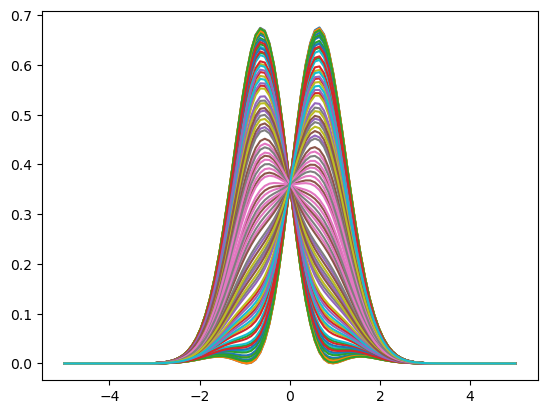

In [7]:
xs = np.linspace(-5,5,100)
plt.plot(xs, np.absolute(psi[0:100,0:100])**2)

In [8]:
def MetodoGradNewton(x, tempo, psi, psiExato):
    
    eps = 0.00000001
    SequenciaPontos = [x]
    
    errox = eps + 1
    xant = x.copy()
    
    errof = eps + 1
    FuncF = Objetivo(tempo, x, psi, psiExato)
    
    k = 0
    kmax = 200
    normagrad = eps + 1
    
    CP = ''
    
    while(CP == ''):
        #print(x)
        d = -1*np.array(gradiente(x, tempo, psi, psiExato))
        #d = -1*(np.matmul(np.linalg.inv(hessiana(x, tempo, psi, psiExato)),gradiente(x, tempo, psi, psiExato)))
        alpha = SecaoAurea(tempo, x, psi, psiExato, d)
        x = x + alpha * d
        
        errox = np.linalg.norm(xant - x)
        xant = x.copy()
        if(errox <= eps):
            CP = CP + 'Erro x '
        normagrad = np.linalg.norm(d)
        if(normagrad <= eps):
            CP = CP + 'Norma Gradiente '
        FuncFx = Objetivo(tempo, x, psi, psiExato)
        errof = abs(FuncF - FuncFx)
        FuncF = FuncFx
        if(errof <= eps):
            CP = CP + 'Erro F '
        if(k >= kmax):
            CP = 'Numero de iteracoes '
            
        k += 1
        SequenciaPontos.append(x)
        
    xOtimo = x
    return SequenciaPontos, k, xOtimo, CP

x = []
x.append(random.uniform(-5, 5))
x.append(random.uniform(-5, 5))
tempo = 0
resultado = MetodoGradNewton(x, tempo, psi, psiExato)
print('iteracoes = ', resultado[1])
print('x = ', resultado[2])
print('Criterio de parada: ', resultado[3])

iteracoes =  201
x =  [-148.53275045    5.77414237]
Criterio de parada:  Numero de iteracoes 


[-4.922085154906297, -3.4132633273561064]
Iteracao =  1
Otimo =  [-148.6229518     5.78942207]
Criterio =  Numero de iteracoes 
---------------
[5.789422071367152, -3.8157506624322046]
Iteracao =  2
Otimo =  [5.83115881 7.17404623]
Criterio =  Erro F 
---------------
[7.1740462325028025, -3.5018949549071046]
Iteracao =  3
Otimo =  [7.17465561 6.98924423]
Criterio =  Erro F 
---------------
[6.989244228827061, -2.8893171465838794]
Iteracao =  4
Otimo =  [6.98983542 6.90393039]
Criterio =  Erro F 
---------------
[6.90393038906681, -4.117528622226673]
Iteracao =  5
Otimo =  [6.90445792 6.90396417]
Criterio =  Erro F 
---------------
[6.903964167125612, -2.4846933999772123]
Iteracao =  6
Otimo =  [6.90448259 6.98930333]
Criterio =  Erro F 
---------------
[6.989303334237333, 0.6535041521334364]
Iteracao =  7
Otimo =  [6.98985815 7.17407156]
Criterio =  Erro F 
---------------
[7.174071556573126, 4.434265654952819]
Iteracao =  8
Otimo =  [7.17465366 7.49095894]
Criterio =  Erro F 
--------

Iteracao =  66
Otimo =  [6.90447553 6.98932111]
Criterio =  Erro F 
---------------
[6.989321110464173, -1.472894732088469]
Iteracao =  67
Otimo =  [6.98987593 7.17406209]
Criterio =  Erro F 
---------------
[7.174062094933152, -3.6370334769903523]
Iteracao =  68
Otimo =  [7.17467148 7.49094295]
Criterio =  Erro F 
---------------
[7.490942952052037, -3.778131521572586]
Iteracao =  69
Otimo =  [7.4916251  8.00211628]
Criterio =  Erro F 
---------------
[8.002116277463992, 0.6238484299707796]
Iteracao =  70
Otimo =  [8.0028439  8.82047807]
Criterio =  Erro F 
---------------
[8.820478067036467, 1.392187754277873]
Iteracao =  71
Otimo =  [ 8.82136032 10.14247224]
Criterio =  Erro F 
---------------
[10.142472243891921, -4.905151350516963]
Iteracao =  72
Otimo =  [10.14353639 12.25793153]
Criterio =  Erro F 
---------------
[12.257931527626786, 4.932326586484455]
Iteracao =  73
Otimo =  [12.25928673 15.29493591]
Criterio =  Erro F 
---------------
[15.29493590919081, 1.1899055446274112]
I

IndexError: index 100 is out of bounds for axis 1 with size 100

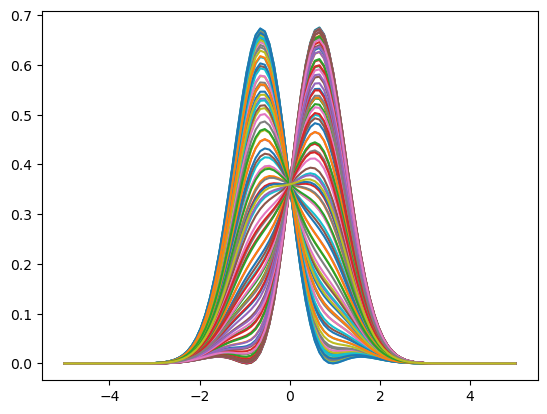

In [9]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,100)

while tempo < 99:
    print(u1)
    psi_g[0:100, tempo] = psi[0:100, tempo]
    plt.plot(xs, np.absolute(psi[0:100, tempo])**2)
    u2 = MetodoGradNewton(u1, tempo, psi, psiExato)
    print("Iteracao = ", (tempo+1))
    print("Otimo = ", u2[2])
    print("Criterio = ", u2[3])
    print("---------------")
    D = multMatrizes(M = 100, us = u2[2][0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(u2[2][1])
    u1.append(random.uniform(-5, 5))

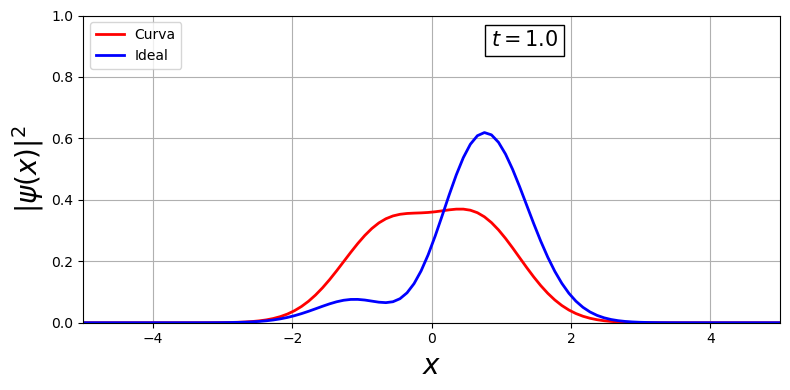

In [10]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,100)
    ln1.set_data(xs, np.absolute(psi_g[0:100,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:100,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Ideal')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=100, interval=200)
ani.save('100x100.gif',writer='pillow',fps=10,dpi=100)